In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

Using MPI version 4.0, 1 processes


O primeiro exemplo é o estudo da propagação do campo eletromagnético em um guia óptico de silício (Si = 3,54) de largura de 1 um. Para tanto, vamos considerar um guia de comprimento de 3 um. A região de simulação será de 5 um em $x$ e 3 um em $y$. Iremos considerar, inicialmente, um simulação 2D. Os passos para definição do ambiente de simulação são:

1. Definir a cécula computacional (região de simulação)
2. Definir os materiais
3. Definir a geometria
4. Definir as fontes ópticas
5. Definir as condições de contorno
6. Definir os monitores de campo
7. Criar os objetos de simulação

### Parâmetros de simulação

Inicialmente, precisamos definir as variáveis utilizadas para definir a dimensão e posição do componente.

In [2]:
sx = 5  # size of cell in X direction
sy = 3  # size of cell in Y direction
sz = 2  # size of cell in Z direction

pad = 0    # padding distance between waveguide and cell edge
w   = 0.5  # Si width (um)
h   = 0.25 # Si height (um)
l   = 5    # Si length (um)

wvg_xcen = 0.5*(sx-l-2*pad)  # x center of horiz. wvg
wvg_ycen = 0  # y center of vert. wvg
wvg_zcen = 0  # y center of vert. wvg

Precisamos definir a frequência do pulso. A unidade de comprimento neste exemplo é 1 um. A frequência da fonte contínua (ContinuousSource) é 0.15 e, portanto, no vácuo, o comprimento de onda é 1/0.15 = 6.67 um e aproximadamente 2 um (1,9245 um) no material (Si=3,54). Vamos considerar 100 pontos ao longo da banda de simulação.

In [3]:
fcen = 1/0.15
df = 0.1     
nfreq = 100  # number of frequencies at which to compute flux
#lambda_min = 0.4            # minimum source wavelength
#lambda_max = 0.8            # maximum source wavelength
#fmin = 1/lambda_max         # minimum source frequency
#fmax = 1/lambda_min         # maximum source frequency
#fcen = 0.5*(fmin+fmax)      # source frequency center
#df = fmax-fmin              # source frequency width

Meep discretiza a estrutura no espaço e tempo, especificada pela variável $resolution$, que descreve o número de pixels por unidade de comprimento. Considerando inicialmente uma resolução de 10 pixels/um, ou 66,7 pixels/comprimento de onda (6.67 um x 10 pixels/um) ou cerca de 20 pixels/um (19,245 pixels/comprimento de onda) no material. Teremos uma 50x30 células ((sx,sy)*resolution).

In [4]:
resolution = 10

Para condições de fronteira, utilizaremos fronteiras absorventes ao redor da célula, do tipo PML (*perfectly matched layers*). Definimos uma largura de 1 um para essas fronteiras.

In [5]:
dpml = .5

### Definir a célula computacional (região de simulação)
Maiores informações https://meep.readthedocs.io/en/latest/Python_User_Interface/#vector3.

In [6]:
cell = mp.Vector3(sx, sy, sz)

### Definir os materiais

In [7]:
from meep.materials import Si

### Definir a geometria

In [8]:
geometry = [mp.Block(size=mp.Vector3(l,w,h),
                     center=mp.Vector3(wvg_xcen,wvg_ycen,wvg_zcen),
                     material=mp.Medium(index=3.54))]

### Definir as fontes ópticas

In [9]:
sources = [
    mp.EigenModeSource(
    mp.ContinuousSource(fcen,fwidth=df),
    component=mp.Ez,
    center=mp.Vector3(-0.5*sx+dpml,wvg_ycen,0),
    size=mp.Vector3(0,4*w,0))
]

/home/adolfofh/mambaforge/lib/python3.9/site-packages/meep/source.py:582: RuntimeWarning: EigenModeSource component is not ALL_COMPONENTS (the default), which makes it non-unidirectional.
  warnings.warn(


### Definir as condições de contorno

In [10]:
## To add an absorbing layer of thickness 1 μm around all sides of the cell
pml_layers = [mp.PML(dpml)] ## PML layers on all axis
# pml_layers = [mp.PML(thickness=dpml,direction=mp.X)] ## PML layers on x axis

### Criar os objetos de simulação

In [11]:
sim = mp.Simulation(cell_size=cell,
                    dimensions=3,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

In [12]:
# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5*sx+dpml+0.5,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

     block, center = (0,0,0)
          size (5,0.5,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.5316,12.5316,12.5316)
     block, center = (0,0,0)
          size (5,0.5,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.5316,12.5316,12.5316)
     block, center = (0,0,0)
          size (5,0.5,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.5316,12.5316,12.5316)


/home/adolfofh/mambaforge/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/adolfofh/mambaforge/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


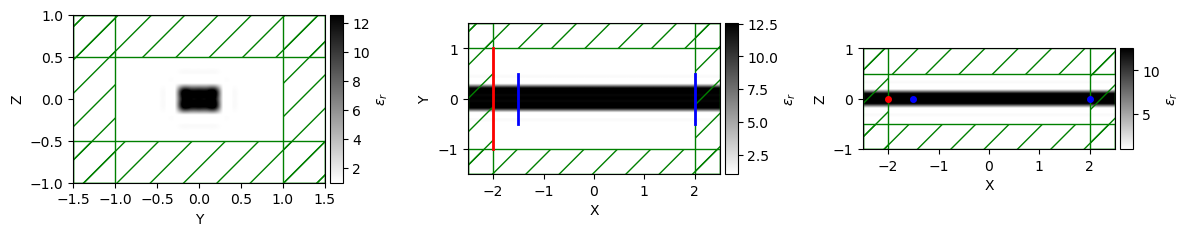

In [13]:
from meep.visualization import Volume
f,ax = plt.subplots(1,3,dpi=100,figsize=(12,6))
sim.plot2D(
    ax=ax[0],
    output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(0,sy,sz)),
    eps_parameters={"colorbar":True}
    )
sim.plot2D(
    ax=ax[1],
    output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sx,sy,0)),
    eps_parameters={"colorbar":True}
    )
sim.plot2D(
    ax=ax[2],
    output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sx,0,sz)),
    eps_parameters={"colorbar":True}
    )
plt.tight_layout()
plt.show()

In [58]:
sim.plot3D()
plt.show()

RFBOutputContext()

     block, center = (0,0,0)
          size (5,0.5,0.25)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.5316,12.5316,12.5316)


In [61]:
#pt = mp.Vector3(0.5 * sx - dpml - 0.5, wvg_ycen)
#sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))
sim.run(until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 6.91414e-06 s
Working in 3D dimensions.
Computational cell is 2 x 5 x 10 with resolution 50
subpixel-averaging is 57.5552% done, 2.95009 s remaining
subpixel-averaging is 56.4057% done, 3.09161 s remaining
subpixel-averaging is 60.1849% done, 2.64635 s remaining
time for set_epsilon = 20.6549 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 0.18/200.0 = 0.1% done in 4.2s, 4615.6s to go
on time step 18 (time=0.18), 0.230661 s/step
Meep progress: 0.42/200.0 = 0.2% done in 8.3s, 3945.8s to go
on time step 42 (time=0.42), 0.172739 s/step
Meep progress: 0.66/200.0 = 0.3% done in 12.4s, 3744.0s to go
on time step 66 (time=0.66), 0.17049 s/step
Meep progress: 0.91/200.0 = 0.5% done in 16.5s, 3613.0s to go
on time step 91 (time=0.91), 0.164705 s/step
Meep progress: 1.1500000000000001/200.0 = 0.6% done in 20.5s, 3548.0s to go
on time step 115 (time=1.15), 0.166835 s/step
Meep progress: 1.3900000000000001/200.0 = 0.7% done in 24.7s, 3523.2s to go
on time step 139 (time=1.39), 0.172427 s/step
Meep progress: 1.6300000000000001/200.0 = 0.8% done in 28.8s, 3504.0s to go
on time step 163 (time=1.63), 0.172267 s/step
Meep progress: 1.8800000000000001/200.0 = 0.9% done in 32.9s, 3469.6s to go
on time step 188 (time=1.88), 0.16525 s/step
Meep progress: 2.12/200.0 = 1.1% done in 37.0s, 3455.6s to go
on time step 212 (time=2.1

### Results

/home/adolfofh/mambaforge/lib/python3.9/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


<AxesSubplot:xlabel='X', ylabel='Y'>

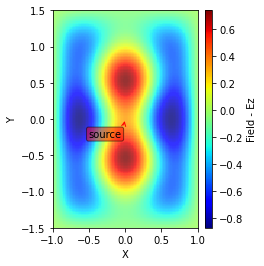

In [24]:
def field_func(x):
    return np.real(x)
field_parameters={
    "alpha": 0.8,
    "cmap": "jet",
    "interpolation": "none",
    "post_process": field_func,
    "colorbar":True,
}
monitor_parameters={
    "offset":30,
    "label_alpha":0.5,
    "label_color":'blue',
}
source_parameters={
    "offset":-20,
    "label_alpha":0.5,
    "label_color":'red',
}
colorbar_parameters={
    "label":'Field - Ez',
    "orientation":'vertical',
    "extend":'neither',
    "format":None,
    "position":'right',
    "size":'5%',
    "pad":'5%',
}
fig=plt.figure(figsize=(12,4))
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sx,sy,0)),
    labels='Teste',
    monitor_parameters=monitor_parameters,
    source_parameters=source_parameters,
    fields=mp.Ez,
    field_parameters=field_parameters,
    colorbar_parameters=colorbar_parameters)

<AxesSubplot:xlabel='X', ylabel='Y'>

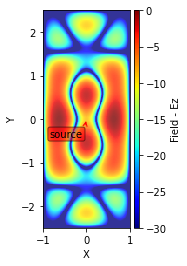

In [20]:
def field_func_dB(x):
    x_dB = 10*np.log10(x*np.conjugate(x))
    x_norm = x_dB - x_dB.max()
    x_norm[np.where(x_norm < -30)] = -30
    return x_norm
field_parameters={
    "alpha": 0.8,
    "cmap": "jet",
    "interpolation": "none",
    "post_process": field_func_dB,
    "colorbar":True,
}
colorbar_parameters={
    "label":'Field - Ez',
    "orientation":'vertical',
    "extend":'neither',
    "format":None,
    "position":'right',
    "size":'5%',
    "pad":'5%',
}
fig=plt.figure(figsize=(12,4))
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(16,16,0)),
    labels='Teste',
    monitor_parameters=monitor_parameters,
    source_parameters=source_parameters,
    fields=mp.Ez,
    field_parameters=field_parameters,
    colorbar_parameters=colorbar_parameters)